# Libraries

In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from scipy.signal import correlate

# Directories


In [2]:
ROOT = Path().resolve().parent      # one level up from current dir
sleep_df = pd.read_excel(ROOT / "data/Sleep/sleep_results.xlsx")
sleep_timecourse_df = pd.read_csv(ROOT / "data/Sleep/all_timeseries_sleep.csv")
wake_timecourse_df = pd.read_csv(ROOT / "data/Sleep/all_timeseries_wake.csv")

# Edit the RC file

In [3]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Set Tick Size

In [4]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [5]:
sleep = sleep_df
sleep_timecourse = sleep_timecourse_df.dropna()
wake_timecourse = wake_timecourse_df.dropna()

# Prep the light sleep and wakefulness dataframes

In [6]:
# First of all we test for amplitude difference, with a repeated measure anova

sleep_anova = sleep.drop(['session', 'start_time', 'session_number', 'Start_TR', 'End_TR'], axis=1)

# drop rows, where sleep stadium wasn't properly assigned
sleep_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['1', '2'])]
wake_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['0'])]

sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
wake_anova_drop['sleep_stage'] = wake_anova_drop['sleep_stage'].astype(int)

# Code sleep stage as categorical variable, so it is not numeric and thus handled categorically rather than calculating linear increase in amplitude, when sleep stage jumps 1 higher
sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 1 else ('b' if x == 2 else 'c'))
sleep_anova_drop['partial_volume_amplitude'] = sleep_anova_drop['partial_volume_amplitude'].astype(int)


wake_anova_drop['sleep_stage_letter'] = wake_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else None)
wake_anova_drop['partial_volume_amplitude'] = wake_anova_drop['partial_volume_amplitude'].astype(int)


# Extract numerical part from 'subID' column
sleep_anova_drop['subID_cat'] = sleep_anova_drop['subID'].str.extract(r'(\d+)')
wake_anova_drop['subID_cat'] = wake_anova_drop['subID'].str.extract(r'(\d+)')
# Convert 'subID_cat' column to numeric type
sleep_anova_drop['subID_cat'] = pd.to_numeric(sleep_anova_drop['subID_cat'])
wake_anova_drop['subID_cat'] = pd.to_numeric(wake_anova_drop['subID_cat'])
#sleep_anova_drop = pd.get_dummies(sleep_anova_drop, columns=['subID_cat'])

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/2253546225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/2253546225.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wake_anova_drop['sleep_stage'] = wake_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/2253546225.py:13: SettingWithCopyWarnin

# Light sleep


# Panel 3A

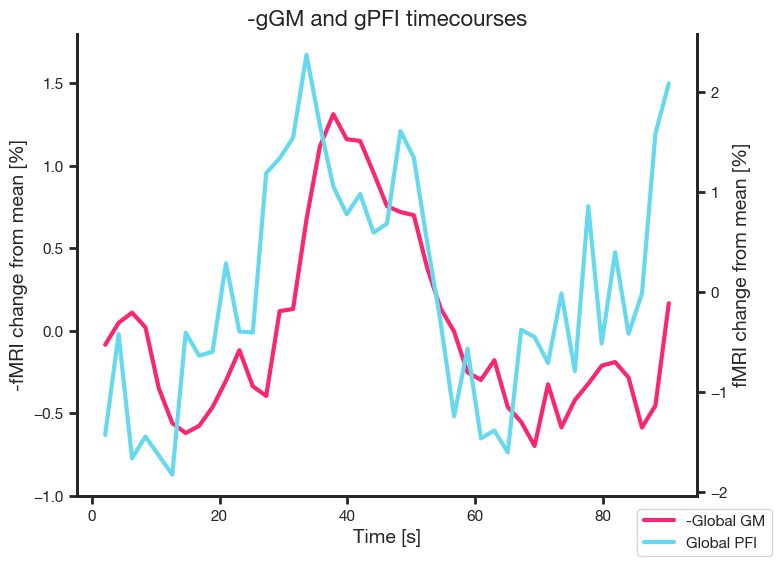

In [16]:
subject_of_choice = 66 


sleep_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
sleep_timecourse_dataframe = sleep_timecourse.iloc[[subject_of_choice]]


# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in sleep_timecourse_dataframe.columns if col.startswith("gm_tc_unfil")]
pfi_tc_columns = [col for col in sleep_timecourse_dataframe.columns if col.startswith("pfi_tc_unfil")]

#print(len(gm_tc_columns))
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([sleep_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)
pfi_values = pd.concat([sleep_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)



sleep_timecourse_new_one = pd.DataFrame()
sleep_timecourse_new_one['timepoints'] = (pd.Series(range(1, len(gm_values) + 1))) * 2.1 # This is the wake/sleep TR
sleep_timecourse_new_one['global_gm'] = -((gm_values * 100) - 100)
sleep_timecourse_new_one['global_pfi'] = (pfi_values * 100) - 100



fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=sleep_timecourse_new_one, ax=ax1, label='-Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=sleep_timecourse_new_one, ax=ax2, label='Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)

# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-fMRI change from mean [%]', fontsize=14)
ax2.set_ylabel('fMRI change from mean [%]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-1,1.8)
#ax2.set_ylim(-3,3)
ax2.tick_params(axis='y')

plt.title(f'-gGM and gPFI timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)

# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_timecourse_1_chunks.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_timecourse_1_chunks.svg')
#fig.savefig(image_path_svg)

# Panel 3B - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-0.5005706928601347


Text(0.6, 0.2, 'Rmin lag = -2.1s')

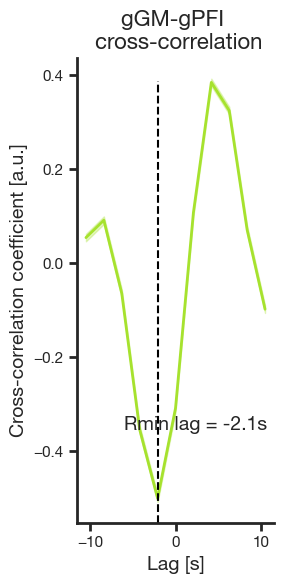

In [17]:

# Extract lag numbers from column names
lag_numbers = [int(col.split('_')[-1]) for col in sleep_anova_drop.columns if col.startswith('xcorr_ventricle_gm_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = sleep_anova_drop[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = sleep_anova_drop[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2.1 # This is the sleep TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmin(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]

print(max_y)

#Adjust so they only show the -10 - 10s mark
time_lags_plot = time_lags_plot[5:-5] 
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]

fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values
xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

plt.title(f'gGM-gPFI \n cross-correlation',fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()
#plt.xlim(-11,11)
plt.text(0.6, 0.2, f"Rmin lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_cross_corr_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_cross_corr_1.svg')
#fig.savefig(image_path_svg)

# Panel 3B - right

Mean: -0.482, Standard Deviation: 0.258
t-statistic: -56.6372799665727
p-value: 2.3771100424446004e-301


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/3682427243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['pair_name'] = "gGM-gPFI"


Text(0.5, 0.97, '****')

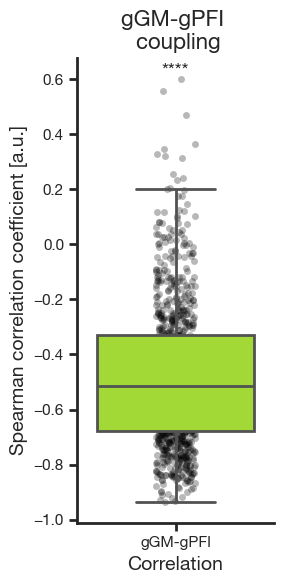

In [18]:
fig = plt.figure(figsize=(3, 6))
sleep_anova_drop['pair_name'] = "gGM-gPFI"

ax = sns.stripplot(data=sleep_anova_drop, x="pair_name", y="r_ventricle_gm",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255) 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=sleep_anova_drop, x="pair_name", y="r_ventricle_gm",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f'gGM-gPFI \n coupling',fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
sns.despine()  # Adjust spines
plt.tight_layout()
#ax.set_xticks([])  # Remove x-axis ticks

# statistic whether it is different to zero
data = sleep_anova_drop['r_ventricle_gm']
#print(data)

mean_val = sleep_anova_drop['r_ventricle_gm'].mean()
std_val = sleep_anova_drop['r_ventricle_gm'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")


# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)

# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_boxplot_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_boxplot_1.svg')
#fig.savefig(image_path_svg)


# Panel 3C

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gm_amplitude_normalized
No. Observations: 916     Method:             REML                   
No. Groups:       33      Scale:              0.2862                 
Min. group size:  2       Log-Likelihood:     -766.1602              
Max. group size:  62      Converged:          Yes                    
Mean group size:  27.8                                               
----------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept               1.452     0.064  22.695  0.000   1.327   1.578
state_name[T.Wake]     -0.306     0.049  -6.207  0.000  -0.403  -0.210
subID Var               0.097     0.052                               

5.385951016492429e-10
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/3899600317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/3899600317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else ('b' if x == 1 else ('c' if x == 2 else 'd')))
/var/folders/ml/8kb9cd2x2

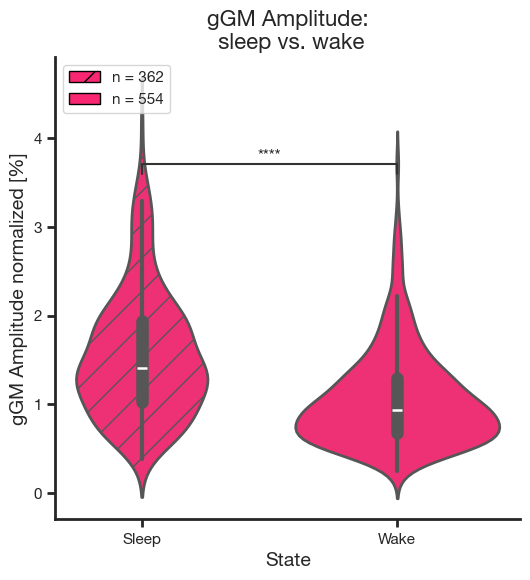

In [20]:
# First of all we test for amplitude difference, with a repeated measure anova

sleep_anova = sleep.drop(['session', 'start_time', 'session_number', 'Start_TR', 'End_TR'], axis=1)

# drop rows, where sleep stadium wasn't properly assigned
sleep_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['0', '1', '2'])]
sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
# Code sleep stage as categorical variable, so it is not numeric and thus handled categorically rather than calculating linear increase in amplitude, when sleep stage jumps 1 higher
sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else ('b' if x == 1 else ('c' if x == 2 else 'd')))
sleep_anova_drop['gm_amplitude_normalized'] = sleep_anova_drop['gm_amplitude_normalized'] * 100

# Extract numerical part from 'subID' column
sleep_anova_drop['subID_cat'] = sleep_anova_drop['subID'].str.extract(r'(\d+)')
# Convert 'subID_cat' column to numeric type
sleep_anova_drop['subID_cat'] = pd.to_numeric(sleep_anova_drop['subID_cat'])



# 1 - B. Anterior vs. Posterior vs. Eroded Correlation Values to occipital

sleep_wake = pd.DataFrame()
sleep_wake['gm_amplitude_normalized'] = pd.concat([sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]['gm_amplitude_normalized'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]['gm_amplitude_normalized'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0]['gm_amplitude_normalized']], axis=0)
sleep_wake['subID'] = pd.concat([sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]['subID'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]['subID'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0]['subID']], axis=0)
# Set values in the second column
sleep_categorical_correlation =  [1] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]) + [1] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]) + [0] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0])
sleep_wake['state_categorical'] = sleep_categorical_correlation
sleep_wake['state_name'] = sleep_wake['state_categorical'].apply(lambda x: "Wake" if x == 0 else "Sleep")


fig = plt.figure(figsize=(6, 6))
ax = sns.violinplot(x="state_name",y='gm_amplitude_normalized',data=sleep_wake, color=(249/255, 38/255, 114/255), saturation=0.9, linewidth=2, inner="box", fill=True)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
sns.despine()  # Adjust spines

for i, violin in enumerate(ax.collections):
    if i == 0:  # Apply pattern to the first violin
        violin.set_hatch('/')  # Apply hatch pattern

# Do a ttest and correct for multiple measures


md = smf.mixedlm("gm_amplitude_normalized ~ state_name", sleep_wake, groups='subID')
mdf = md.fit()
print(mdf.summary())





# Get the current axis
ax = plt.gca()

# Add statistical annotations
plotting_parameters = {
            'data':    sleep_wake,
            'x':       'state_name',
            'y':       'gm_amplitude_normalized',
            #'y':       'tfi',
            #'hue':     'subID'
        }

         
         
pairs = [('Sleep', 'Wake')]       

# Extract p-value
pvalue = mdf.pvalues['state_name[T.Wake]']
print(pvalue)

# Initialize an empty list to store formatted p-values
formatted_pvalues_list = []

# Format p-value
if pvalue <= 1e-4:
    formatted_pvalue = '****'
elif pvalue <= 1e-3:
    formatted_pvalue = '***'
elif pvalue <= 1e-2:
    formatted_pvalue = '**'
elif pvalue <= 5e-2:
    formatted_pvalue = '*'
else:
    formatted_pvalue = 'ns'
    
# Convert single p-value to a list
formatted_pvalues_list = [formatted_pvalue]


# Set custom annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.set_custom_annotations(formatted_pvalues_list)
annotator.annotate()

# Coupling Gruppe - Annot
plt.title(f'gGM Amplitude:\n sleep vs. wake',fontsize = 16, weight = 'bold')
plt.xlabel('State', fontsize = 14)
plt.ylabel('gGM Amplitude normalized [%]', fontsize = 14)



# new way:
legend_patches = [
    Patch(facecolor=(0.9764705882352941, 0.14901960784313725, 0.4470588235294118), edgecolor='black', hatch='/', label=f'n = {len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]) + len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2])}'), 
    Patch(facecolor=(0.9764705882352941, 0.14901960784313725, 0.4470588235294118), edgecolor='black', label=f'n = {len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0])}')
]

# Add legend with custom patches
ax.legend(handles=legend_patches, loc='upper left')

# Save the figure -------
#image_path = os.path.join(outDir, f'Difference in GM amplitude different states normalized.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Difference in GM amplitude different states normalized.svg')
#fig.savefig(image_path_svg)

# Wakefulness

# Panel 3D

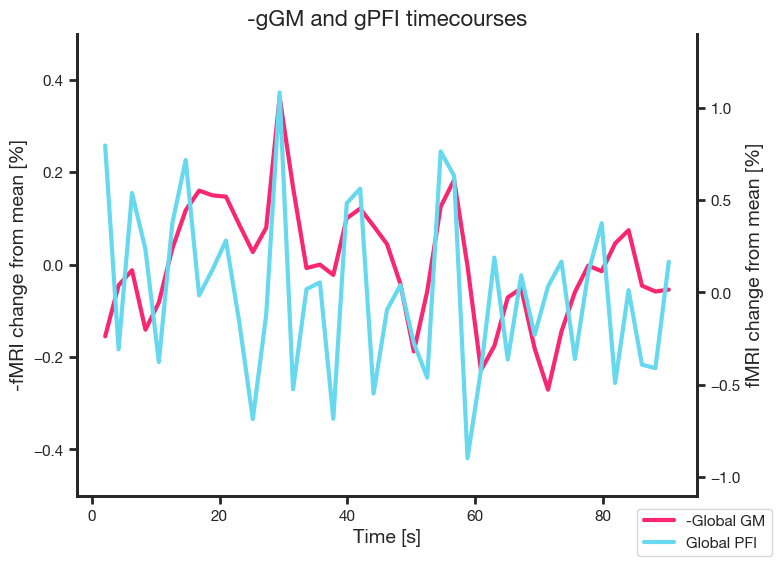

In [21]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})


subject_of_choice = 23 



wake_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
wake_timecourse_dataframe = wake_timecourse.iloc[[subject_of_choice]]

# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in wake_timecourse_dataframe.columns if col.startswith("gm_tc_unfil")]
pfi_tc_columns = [col for col in wake_timecourse_dataframe.columns if col.startswith("pfi_tc_unfil")]

#print(len(gm_tc_columns))
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([wake_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)

pfi_values = pd.concat([wake_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)



wake_timecourse_new_one = pd.DataFrame()
wake_timecourse_new_one['timepoints'] = (pd.Series(range(1, len(gm_values) + 1))) * 2.1 # This is the wake/sleep TR
wake_timecourse_new_one['global_gm'] = -((gm_values * 100) - 100)
wake_timecourse_new_one['global_pfi'] = (pfi_values * 100) - 100



fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=wake_timecourse_new_one, ax=ax1, label='-Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=wake_timecourse_new_one, ax=ax2, label='Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)


# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-fMRI change from mean [%]', fontsize=14)
ax2.set_ylabel('fMRI change from mean [%]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-0.5,0.5)
ax2.set_ylim(-1.1,1.4)
ax2.tick_params(axis='y')

plt.title(f'-gGM and gPFI timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)

# Save the figure -------
#image_path = os.path.join(outDir, f'Wake_timecourse_1_chunks.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_timecourse_1_chunks.svg')
#fig.savefig(image_path_svg)

# Panel 3E - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-2.1
-0.4632990277539697


Text(0.6, 0.2, 'Rmin lag = -2.1s')

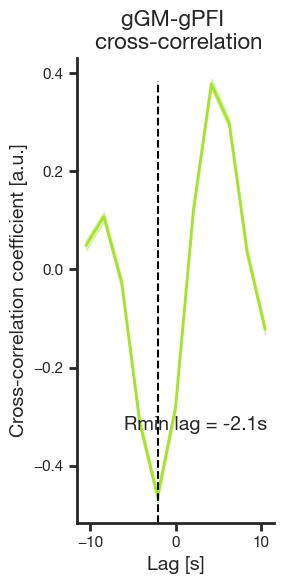

In [23]:
# Extract lag numbers from column names
lag_numbers = [int(col.split('_')[-1]) for col in wake_anova_drop.columns if col.startswith('xcorr_ventricle_gm_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = wake_anova_drop[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = wake_anova_drop[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2.1 # This is the sleep TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmin(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]
print(max_x)
print(max_y)

#Adjust so they only show the -10 - 10s mark
time_lags_plot = time_lags_plot[5:-5] # This is the sleep TR
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]

fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed


xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

plt.title(f'gGM-gPFI \n cross-correlation',fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()


plt.text(0.6, 0.2, f"Rmin lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Wake_cross_corr_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_cross_corr_1.svg')
#fig.savefig(image_path_svg)

# Panel 3E - right

Mean: -0.433, Standard Deviation: 0.263
t-statistic: -38.648010484670635
p-value: 2.866418068362971e-159


Text(0.5, 0.97, '****')

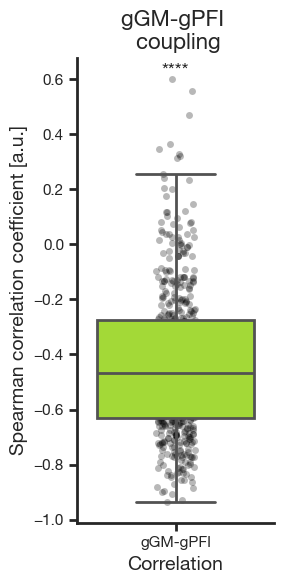

In [24]:
# 2 - A. Prove that the correlation values across subjects and modalities show similar distribution
wake_anova_drop['pair_name'] = "gGM-gPFI"

fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=wake_anova_drop, x="pair_name", y="r_ventricle_gm",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255) 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=wake_anova_drop, x="pair_name", y="r_ventricle_gm",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f'gGM-gPFI \n coupling',fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
sns.despine()  # Adjust spines
plt.tight_layout()


# statistic whether it is different to zero
data = wake_anova_drop['r_ventricle_gm']
#print(data)
mean_val = wake_anova_drop['r_ventricle_gm'].mean()
std_val = wake_anova_drop['r_ventricle_gm'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")
# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)

# Save the figure -------
#image_path = os.path.join(outDir, f'Wake_boxplot_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_boxplot_1.svg')
#fig.savefig(image_path_svg)

# Panel 3F

5      3.266739
23     1.899116
28     4.082762
46     3.916975
51     1.738227
         ...   
932    2.168851
933    2.070926
934    1.417976
935    1.970454
936    3.577399
Name: pfi_norm, Length: 916, dtype: float64
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  pfi_norm  
No. Observations:    916      Method:              REML      
No. Groups:          33       Scale:               1.1837    
Min. group size:     2        Log-Likelihood:      -1420.5703
Max. group size:     62       Converged:           Yes       
Mean group size:     27.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.156    0.151 20.879 0.000  2.860  3.453
state_name[T.Wake] -0.390    0.101 -3.865 0.000 -0.587 -0.192
subID Var           0.592    0.155              

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/1827399823.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5834/1827399823.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else ('b' if x == 1 else ('c' if x == 2 else 'd')))
/var/folders/ml/8kb9cd2

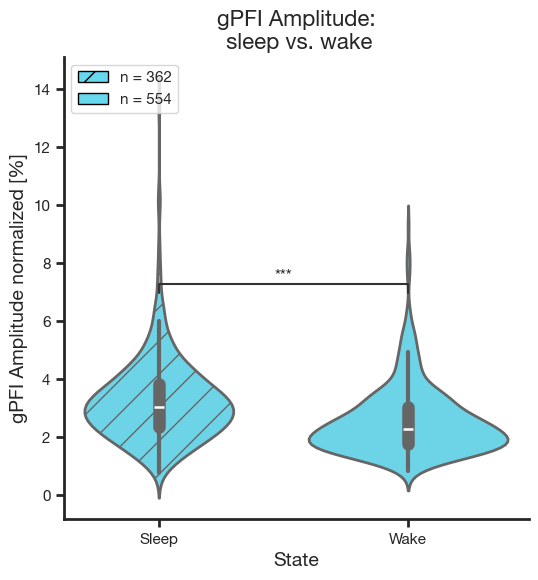

In [26]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# First of all we test for amplitude difference, with a repeated measure anova

sleep_anova = sleep.drop(['session', 'start_time', 'session_number', 'Start_TR', 'End_TR'], axis=1)

# drop rows, where sleep stadium wasn't properly assigned
sleep_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['0', '1', '2'])]
sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)

sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else ('b' if x == 1 else ('c' if x == 2 else 'd')))
sleep_anova_drop['partial_volume_amplitude'] = sleep_anova_drop['partial_volume_amplitude'].astype(int)
sleep_anova_drop['partial_volume_amplitude_normalized'] = sleep_anova_drop['partial_volume_amplitude_normalized']*100

# Extract numerical part from 'subID' column
sleep_anova_drop['subID_cat'] = sleep_anova_drop['subID'].str.extract(r'(\d+)')
sleep_anova_drop['subID_cat'] = pd.to_numeric(sleep_anova_drop['subID_cat'])

sleep_wake = pd.DataFrame()
sleep_wake['tfi'] = pd.concat([sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]['partial_volume_amplitude'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]['partial_volume_amplitude'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0]['partial_volume_amplitude']], axis=0)
sleep_wake['pfi_norm'] = pd.concat([sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]['partial_volume_amplitude_normalized'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]['partial_volume_amplitude_normalized'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0]['partial_volume_amplitude_normalized']], axis=0)
sleep_wake['subID'] = pd.concat([sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]['subID'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]['subID'],sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0]['subID']], axis=0)
# Set values in the second column
sleep_categorical_correlation = [1] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]) + [1] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2]) + [0] * len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0])
sleep_wake['state_categorical'] = sleep_categorical_correlation
sleep_wake['state_name'] = sleep_wake['state_categorical'].apply(lambda x: "Wake" if x == 0 else "Sleep")

print(sleep_wake['pfi_norm'])

fig = plt.figure(figsize=(6, 6))

ax = sns.violinplot(x="state_name",y='pfi_norm',data=sleep_wake, color=(102/255, 217/255, 239/255), saturation=0.9, linewidth=2, inner="box", fill=True)

ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
sns.despine()  # Adjust spines

for i, violin in enumerate(ax.collections):
    if i == 0:  # Apply pattern to the first violin
        violin.set_hatch('/')  # Apply hatch pattern

# Do a ttest and correct for multiple measures

#md = smf.mixedlm("tfi ~ state_name", sleep_wake, groups='subID')
md = smf.mixedlm("pfi_norm ~ state_name", sleep_wake, groups='subID')
mdf = md.fit()
print(mdf.summary())





# Get the current axis
ax = plt.gca()

# Add statistical annotations
plotting_parameters = {
            'data':    sleep_wake,
            'x':       'state_name',
            'y':       'pfi_norm',

        }

         
         
pairs = [('Sleep', 'Wake')]       

# Extract p-value
pvalue = mdf.pvalues['state_name[T.Wake]']
print(pvalue)

# Initialize an empty list to store formatted p-values
formatted_pvalues_list = []

# Format p-value
if pvalue <= 1e-4:
    formatted_pvalue = '****'
elif pvalue <= 1e-3:
    formatted_pvalue = '***'
elif pvalue <= 1e-2:
    formatted_pvalue = '**'
elif pvalue <= 5e-2:
    formatted_pvalue = '*'
else:
    formatted_pvalue = 'ns'
    
# Convert single p-value to a list
formatted_pvalues_list = [formatted_pvalue]


# Set custom annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.set_custom_annotations(formatted_pvalues_list)
annotator.annotate()

# Coupling Gruppe - Annot
plt.title(f'gPFI Amplitude:\n sleep vs. wake',fontsize = 16, weight = 'bold')
plt.xlabel('State', fontsize = 14)
plt.ylabel('gPFI Amplitude normalized [%]', fontsize = 14)



legend_patches = [
    Patch(facecolor=(102/255, 217/255, 239/255), edgecolor='black', hatch='/', label=f'n = {len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 1]) + len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 2])}'),
    Patch(facecolor=(102/255, 217/255, 239/255), edgecolor='black', label=f'n = {len(sleep_anova_drop[sleep_anova_drop['sleep_stage'] == 0])}')
]

# Add legend with custom patches
ax.legend(handles=legend_patches, loc='upper left')

# Save the figure -------
#image_path = os.path.join(outDir, f'Difference in PFI amplitude different states normalized.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Difference in PFI amplitude different states normalized.svg')
#plt.savefig(image_path_svg)